# Approximate counting Bloom filter

A Bloom filter is a widely-used data structure that is efficient in answering membership queries, which means asking if an element belong to the data structure. It is guaranteed that Bloom filter always answer any membership query with no false negatives, and the probability of false-positive answers can be analyzed with simple theoretical work. Bloom filters are widely use in web data search, network data analysis and genomic dataset comparison.

Despite all the nice properties of a Bloom filter, it doesn't support deletions (remove items from the data structure after they are inserted), complicate some applications that prefer more flexibility. Therefore, an extented data structure called counting Bloom filter (CBF) is proposed. A counting Bloom filter records counts for each bin in the filter, instead of bits for a typical Bloom filter. The advantage of storing counts is the capability of deletions, and a "thresholding membership query" -- asking if an item belongs to the filter with occurrences over a given threshold.

However, replacing bits with counts in a Bloom filter greatly increases the space usage of the data structure. Also, for many scenarios people need to set the size of each bin in the filter based on some high-frequency elements, resulting in wasted bits for many other bins. To deal with this issue, we propose a probabilistic approach for updating counts in the counting Bloom filter. We call this method **approximate counting Bloom filter**.

In [1]:
import xxhash

import random
import sys
import math

from matplotlib import rcParams
from matplotlib import style
import matplotlib.pyplot as plt

style.use('fivethirtyeight')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Trebuchet MS']
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['xtick.color'] = 'grey'
plt.rcParams['ytick.color'] = 'grey'

from IPython.display import clear_output
%config InlineBackend.figure_format = 'retina'


## Implement hashing and counting Bloom filter objects

`xxhash` library is used for hashing.

In [2]:
# control random seed for reproducibility
random.seed(0)

class HashXX32:
    def __init__(self, seed):
        self.h = xxhash.xxh32(seed=seed)

    def hash(self, o):
        self.h.reset()
        self.h.update(o)
        return self.h.intdigest() % sys.maxsize

class CountingBloomFilter:
    def __init__(
        self,
        num_hash,
        size,
        seed = [],
        verbose = 0,
        max_size = sys.maxsize
    ):
        # num_hash (Int): 
        #     number of hash functions, usually denote as k
        # size (Int): 
        #     size of the filter
        # seed (List) [[]]: 
        #     list of length num_hash; can be None and the seed will be randomly generated
        # verbose (Int) [0]:
        #     increment to raise verbose level
        # max_size (Int) [sys.maxsize]:
        #     the max value of a count
        
        # Randomly decide seeds if not set
        if not seed or len(seed) != num_hash:
            seed = []
            for i in range(num_hash):
                seed.append(random.randint(0, sys.maxsize - 1))
        self.list_hasher = [HashXX32(s) for s in seed]
        self.num_hash = num_hash
        self.size = size
        self.table = [0] * size
        self.verbose = verbose
        self.max_size = max_size
    
    def __del__(self):
        seed = None
        self.list_hasher = None
        self.table = None
        self.seed = None
        self.verbose = 0
        self.max_size = sys.maxsize

    def insert(self, obj):
        # Insert the object into the data structure.
        # For each insertion, increment the count by 1
        
        for i in range(self.num_hash):
            try:
                list_target_idx = self.list_hasher[i].hash(obj) % self.size
            except:
                print (self.num_hash)
                print (len(self.list_hasher))
                print (i)
                print (self.list_hasher)
                print (obj)
            
            if self.table[list_target_idx] < self.max_size:
                self.table[list_target_idx] += 1
            # Do not update if the bin has reached max_size (print warning if verbose > 0)
            elif self.verbose > 0:
                print (f'fail to increment bin {list_target_idx} when inserting item {obj} because the bin has reached max_size')

            # Print each step if verbose > 1
            if self.verbose > 1:
                print (f'insert {obj} to {list_target_idx}')
                
    def delete(self, obj):
        # Delete the object from the data structure.
        # For each deletion, decrement the count by 1 if its value > 0
        
        # First check if obj is in the filter
        if obj not in self:
            print (f'cannot perform delete(): item {obj} is not in the filter')
            return
        
        for i in range(self.num_hash):
            list_target_idx = self.list_hasher[i].hash(obj) % self.size
            
            if self.table[list_target_idx] > 0:
                self.table[list_target_idx] -= 1
            # Don't decrement if the count is already 0
            elif self.verbose > 0:
                print (f'fail to decrement bin {list_target_idx} when deleting item {obj} because the bin count is already 0')

            # Print each step if verbose > 1
            if self.verbose > 1:
                print (f'delete {obj} from {list_target_idx}')
                
    def __contains__(self, obj):
        # Return True if the object has been added; False if not
        # Don't consider counts here
        for i in range(self.num_hash):
            list_target_idx = self.list_hasher[i].hash(obj) % self.size
            if self.verbose > 0:
                print (f'item {obj} hashed to bin {list_target_idx}')
            if self.table[list_target_idx] == 0:
                return False
        return True
    
    def thresholding_contain(self, obj, threshold):
        # Return True if the min count associated with obj >= threshold; False if not
        for i in range(self.num_hash):
            list_target_idx = self.list_hasher[i].hash(obj) % self.size
            if self.verbose > 0:
                print (f'item {obj} hashed to bin {list_target_idx}, the count of which is {self.table[list_target_idx]}')
            if self.table[list_target_idx] < threshold:
                return False
        return True

    def print_filter(self):
        # Print CBF
        print (self.table)
    
    def estimate_size(self):
        # Return estimated size of the CBF
        return (self.size * math.ceil(math.log2(self.max_size)))
        

Also, we prepare some functions for plotting later:

In [3]:
def plot_hist(input_stream):
    '''
    Given an input stream, plot the histogram of its components
    '''
    # Get counts for each distinct kmer
    list_count = []
    for s in set(input_stream):
        list_count.append(input_stream.count(s))
    
    # Plot histogram
    fig, ax = plt.subplots(figsize=(10,3))

    ax.set_title('Distribution of kmer multiplicity', loc = 'left')
    ax.set_xlabel('Kmer multiplicity')
    ax.set_ylabel('Number of kmers')

    hist_n, hist_bins, hist_patches = plt.hist(list_count, log=True, bins=100)
    plt.show()

def plot_lineplot_FPR(x, list_y, list_label, theta, opt = False):
    '''
    Plot a lineplot for a FPR experiment

    x (List): range of data
    list_y (List of Lists): FPR values, each experiment has a List
    list_label (List of Strings): labels, each experiment as a String
    theta (Int): threshold of a query
    opt (Bool) [False]: whether to show opt result
    '''

    fig, ax = plt.subplots(figsize=(10,4))
    ax.set_title(r'False positive rate of thresholding membership query ($\theta = $' + f'${theta}$) for counting Bloom filter', loc = 'left')
    ax.set_xlabel(f'Number of hash functions ($k$)')
    ax.set_ylabel('False positive rate')
    ax.set_yscale("log", nonposy='clip')
    for i, y in enumerate(list_y):
        plt.plot(x, y, 'o-', lw = 0.7, markersize = 4, label = f'{list_label[i]}')
        if opt:
            k_opt = x[y.index(min(y))]
            y_opt = y[k_opt - 1]
            plt.plot(k_opt, y_opt, 'ro', markersize=5, label = r'$k_{opt}$')
    ax.legend(loc = 'right')
    plt.show()

## Testing using a small example

We use a small test case to test our counting Bloom filter.
For this example, we print messages showing filter saturation during insertion and queries.

We'd like to know:
- the size of the data structure (this is the evaluated number, not actual memory usage, because we're just prototyping)

In [4]:
# test case: "countingbloomfilter", 3 hash functions, 30 bins
list_obj = list("countingbloomfilter")
test_cbf = CountingBloomFilter(num_hash = 3, size = 30, verbose = 1, max_size = 5)
size_test_cbf = test_cbf.estimate_size()
print (f'TestCBF is estimated to use {size_test_cbf} bits ({test_cbf.size}x{math.ceil(math.log2(test_cbf.max_size))})')

TestCBF is estimated to use 90 bits (30x3)


- what the filter is after insertion is completed

As the messages demonstrate, the actual count of $\text{bin}_{24}$ should be 9, but it is saturated at 5 becuase of the `max_size` we set.

In [5]:
for obj in list_obj:
    test_cbf.insert(obj)

print ('TestCBF after insertion:')
test_cbf.print_filter()

fail to increment bin 24 when inserting item f because the bin has reached max_size
fail to increment bin 24 when inserting item i because the bin has reached max_size
fail to increment bin 24 when inserting item i because the bin has reached max_size
fail to increment bin 24 when inserting item t because the bin has reached max_size
TestCBF after insertion:
[0, 0, 0, 5, 0, 2, 2, 0, 3, 0, 0, 2, 2, 2, 1, 4, 1, 2, 0, 3, 3, 1, 2, 4, 5, 1, 4, 2, 2, 0]


- if it works well for membership queries

We'll see examples of a true-positive (`'i'`), a false-positive (`'x'`) and a true-negative (`'y'`) membership query.

In [6]:
print ('Testing character "i", which is an input element')
print ('i' in test_cbf)
print ()

print ('Testing character "x", which is not an input element')
print ('x' in test_cbf)
print ('*TestCBF returns True for "x", which is due to collision\n')

print ('Testing character "y", which is not an input element')
print ('y' in test_cbf)

Testing character "i", which is an input element
item i hashed to bin 24
item i hashed to bin 13
item i hashed to bin 24
True

Testing character "x", which is not an input element
item x hashed to bin 24
item x hashed to bin 21
item x hashed to bin 16
True
*TestCBF returns True for "x", which is due to collision

Testing character "y", which is not an input element
item y hashed to bin 2
False


In [7]:
print (f'Testing character "u", which occurs {list_obj.count("u")} in the input stream')
print (test_cbf.thresholding_contain('u', 2))
print ()

print (f'Testing character "i", which occurs {list_obj.count("i")} times in the input stream')
print (test_cbf.thresholding_contain('i', 2))
print ()

Testing character "u", which occurs 1 in the input stream
item u hashed to bin 24, the count of which is 5
item u hashed to bin 21, the count of which is 1
False

Testing character "i", which occurs 2 times in the input stream
item i hashed to bin 24, the count of which is 5
item i hashed to bin 13, the count of which is 2
item i hashed to bin 24, the count of which is 5
True



- deletion

## Experiment using genomic kmers

We extract 6-mers from a 10 kb DNA sequence human chromosome 21 (10,000,000,-10,100,000) to perform experiments for our data structures.
`N`s are removed.

In [8]:
fn = 'hg19-chr21-10000000_10100000.fa'

seq = ''
with open(fn, 'r') as f:
    for line in f:
        if line[0] != '>':
            seq += line.rstrip()

# Remove all Ns (there is a big chunk of Ns in the selected region)
seq = seq.replace('N', '')

size_kmer = 6
list_kmer = []
for i in range(len(seq) - size_kmer + 1):
    list_kmer.append(seq[i : i + size_kmer])
set_kmer = set(list_kmer)

print (f'Number of kmers: {len(list_kmer)}')
print (f'Number of distinct kmers: {len(set_kmer)}')

Number of kmers: 49996
Number of distinct kmers: 3655


Plot the distribution kmer multiplicity. 
Most kmers have few occurrences.

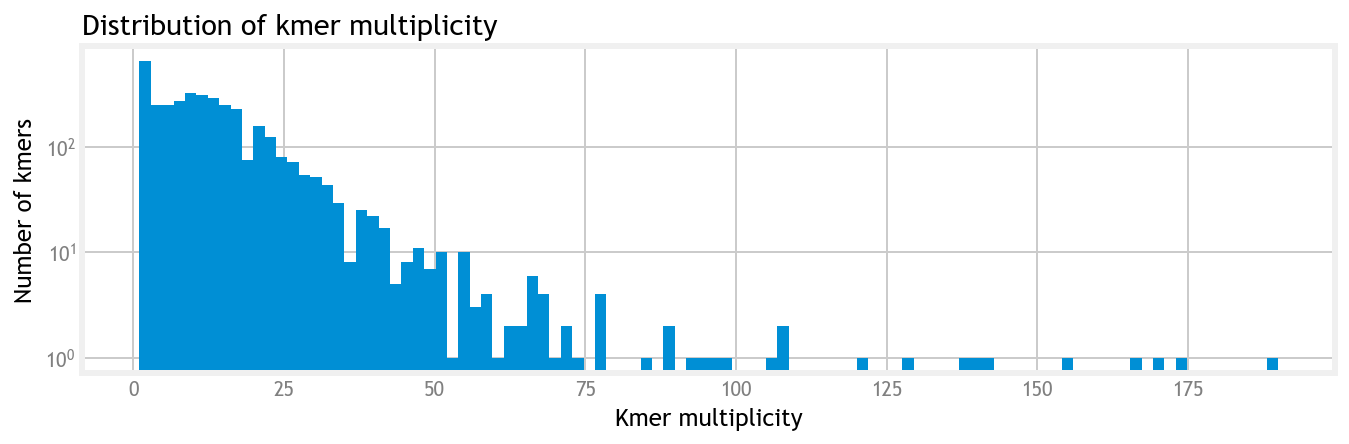

In [9]:
plot_hist(list_kmer)

There are 49996 kmers in the input stream ($m =$ 49996), and let's set the size of the filter $n$ to be 16384, giving a $\frac{n}{m}$ value of 0.33.

### Find optimal number of hash functions in theory

Previous theoretical work (Kim et al., 2019) has provided a systematic approach to find the optimal number of hash functions $k_{opt}$ when performing thresholding membership query with a threshold $\theta$.
Again, $n$ is the size of the counting Bloom filter, and $m$ is the size of the input set.

First, the false positive probability $p_{fp}$ can be approximated as 

$\hat{p}_{fp}(\theta, k, n, m) \approx (1 - \frac{\Gamma(\theta, \kappa)}{\Gamma(\theta, 0)})^k$,

where $\kappa = \frac{km}{n}$ and $\Gamma(\theta, \kappa) = \int_\kappa^\infty t^{\theta - 1}e^{-t}dt$.

To find $k_{opt}$, first we compute $\hat{p}_{fp}(\theta, 1, n, m)$.
Then $k$ is repeatedly incremented by 1 and $\hat{p}_{fp}$ is updated.
This process stops when $\hat{p}_{fp}$ starts to increase, or $k = (\theta + 1) m / n$.
We can find $k_{opt}$ by selecting the $k$ results in smallest $\hat{p}_{fp}$.

The definition of $\Gamma(\theta, \kappa)$ used by Kim et al. is different from what is used in Scipy, where $\Gamma(z) = \int_0^\infty t^{z - 1}e^{-t}dt$ (`scipy.gamma`) and $Q(a, x) = \frac{1}{\Gamma(a)} \int_x^\infty t^{a - 1}e^{-t}dt$ (`scipy.gammaincc`).
Thus, the $\Gamma(\theta, \kappa)$ needs to be computed by $Q(\theta, \kappa) \Gamma(\theta)$.

In [10]:
from scipy.special import gamma, gammaincc

theta = 8
size_input = len(list_kmer)#len(set_kmer)
size_filter = 16384 #65536 #32768 

# There may be a typo in Kim et al.'s paper, need to check further
# k_upper_limit = math.ceil((theta + 1) * size_input / size_filter)
k_upper_limit = math.ceil((theta + 1) * size_filter / size_input)

list_k = []
list_fp_thry = []

for k in range(1, theta):
# for k in range(1, k_upper_limit):
    kappa = k * size_input / size_filter
    gamma_k = gammaincc(theta, kappa) * gamma(theta)
    gamma_0 = gamma(theta)
    p_fp_new = (1 - (gamma_k / gamma_0)) ** k

    list_k.append(k)
    list_fp_thry.append(p_fp_new)

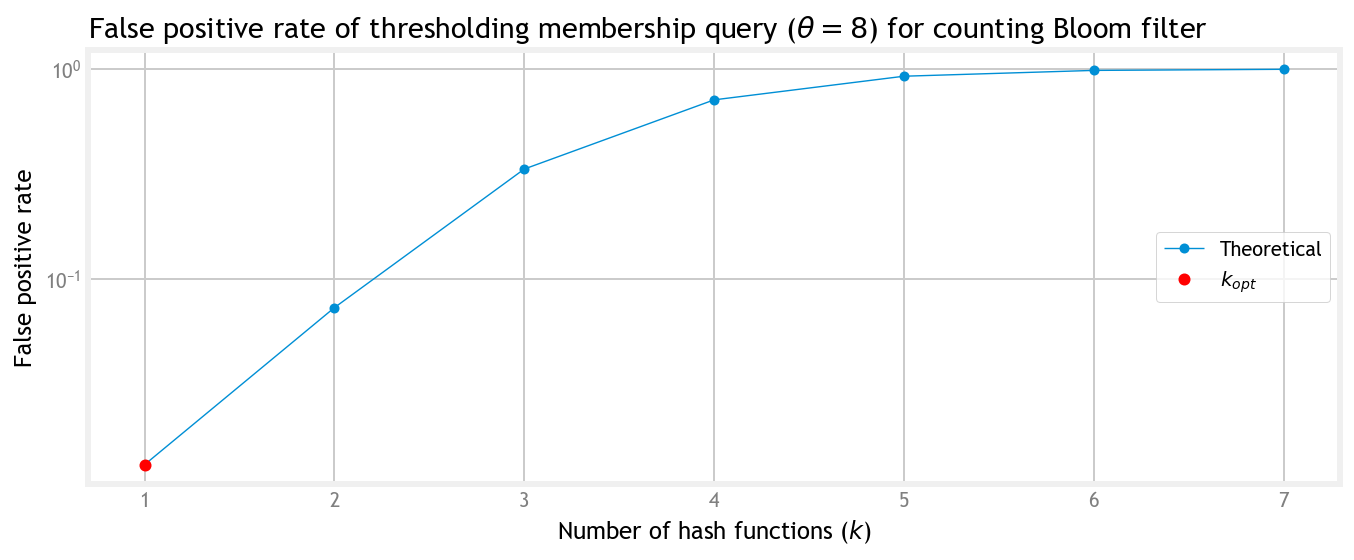

In [11]:
plot_lineplot_FPR(x = list_k, list_y = [list_fp_thry], list_label = ['Theoretical'], theta = theta, opt = True)

The theoretical work above suggests us use 1 hash functions.

Next, we move on to actually test the counting Bloom filter with our DNA 6-mer data.

### Empirical $k_{opt}$ for the counting Bloom filter

First we construct true (with multiplicity $\geq \theta$) and false sets among all possible 6-mers.
All kmers are divided into `true_set` and `false_set`.
Kmers belong to `true_set` occurred more than 8 times in the input stream; others belong to `false_set`.

In [12]:
# Test all possible kmers
import itertools

all_possible_kmers = [''.join(x) for x in itertools.product('ACGT', repeat = size_kmer)]
true_set = []
for x in all_possible_kmers:
    if list_kmer.count(x) >= theta:
        true_set.append(x)
true_set = set(true_set)
false_set = [x for x in set(all_possible_kmers) - true_set]

print (f'Number of all possible {size_kmer}-mers = {len(all_possible_kmers)}')
print (f'Number of true {size_kmer}-mers = {len(true_set)}')
print (f'Number of false {size_kmer}-mers = {len(false_set)}')

Number of all possible 6-mers = 4096
Number of true 6-mers = 2390
Number of false 6-mers = 1706


Then we scan through all valid number of hash functions to find the best parameter that gives lowest false positive rate.


To begin, we prepare the script that insert the test input data to CBFs with different $k$ values.

In [13]:
def evaluate_fpr_with_data(
    list_k,
    size_filter,
    theta,
    input_stream,
    true_set,
    false_set,
    max_size = sys.maxsize,
    seed = 0
):
    random.seed(seed)
    list_tp, list_fn, list_fp, list_tn = [], [], [], []

    for k in list_k:
        cbf = CountingBloomFilter(num_hash = k, size = size_filter, max_size = max_size)

        # Insertion
        for kmer in input_stream:
            cbf.insert(kmer)

        num_tp, num_tn, num_fp, num_fn = 0, 0, 0, 0
        for kmer in true_set:
            if cbf.thresholding_contain(kmer, theta):
                num_tp += 1
            else:
                num_fn += 1
        for kmer in false_set:
            if cbf.thresholding_contain(kmer, theta):
                num_fp += 1
            else:
                num_tn += 1

        total = len(true_set) + len(false_set)
        list_tp.append(num_tp / total)
        list_fn.append(num_fn / total)
        list_fp.append(num_fp / total)
        list_tn.append(num_tn / total)

        del cbf
    return list_tp, list_fn, list_fp, list_tn

Now we're ready to perform empirical FPR experiment:

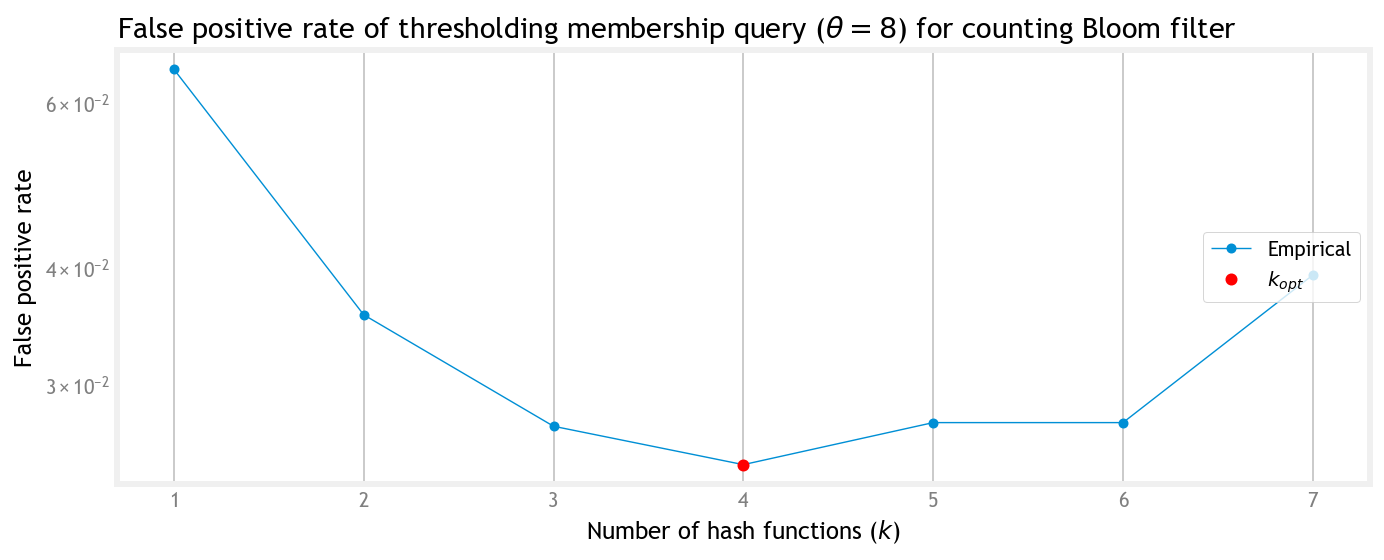

In [14]:
list_tp_emp, list_fn_emp, list_fp_emp, list_tn_emp = evaluate_fpr_with_data(
    list_k = list_k,
    size_filter = size_filter,
    theta = theta,
    input_stream = list_kmer,
    true_set = true_set,
    false_set = false_set
)
plot_lineplot_FPR(x = list_k, list_y = [list_fp_emp], list_label = ['Empirical'], theta = theta, opt = True)

After comparing empirical results with our theoretical work, it is obvious the empirical and theoretical results are not matched.

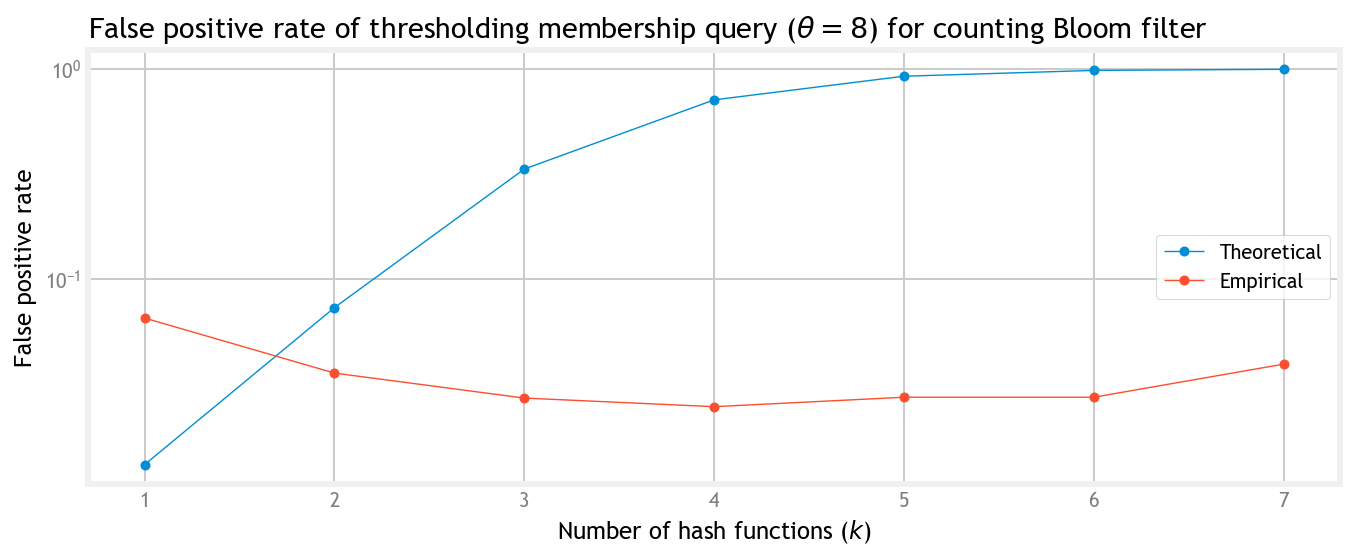

In [15]:
plot_lineplot_FPR(x = list_k, list_y = [list_fp_thry, list_fp_emp], list_label = ['Theoretical', 'Empirical'], theta = theta, opt = False)

### Using simulated data to evaluate false positive rate

To further investigate the reason of the gap, we generate a simulated dataset and evaluate FPR using it.
The purpose of this simulation experiment is to remove the un-randomness of genomics data, and we expect we'll obtain results more similar to the theoretical work.

In [21]:
def simulate_random_data(size_input_space, theta):
    '''
    Simulate random points (we use str(Int) to make it hashable) from an input space
    
    Args:
    - size_input_space (Int): define how large the space is for simulation
    - theta (Int): thresholding membership query parameter
    
    Returns:
    - random_dataset (List): 
        A list of str(Int)'s that are randomly generated from space R^{size_input_space}
    - true_set (Set): 
        A set of elements that occured >= theta times in `random_dataset`
    - false_set (Set):
        A set of elements that are in input space but not in `true_set`
    '''
    random.seed(0)
    random_dataset = []
    for i in list_kmer:
        random_dataset.append(str(random.randint(0, size_input_space - 1)))

    true_set = []
    for x in set(random_dataset):
        if random_dataset.count(x) >= theta:
            true_set.append(x)
    true_set = set(true_set)
    # If input space is too large, we might consider testing approximated FPR using only the input elements
    # false_set = set(random_dataset) - true_set
    false_set = set([str(x) for x in set(range(size_input_space))]) - true_set

    print (f'Size of input space = {size_input_space}')
    print (f'Number of simulated data = {len(random_dataset)}')
#     print (random_dataset[:10])
    print (f'Size of true set = {len(true_set)}')
    print (f'Size of false set = {len(false_set)}')
    
    return random_dataset, true_set, false_set

In [26]:
# input_space_params = [4, 8]
input_space_params = [4, 8, 16, 32, 64]
list_random_dataset, list_true_set_sim, list_false_set_sim = [], [], []
for q in input_space_params:
    print (f'Input space multiplier: {q}')
    out = simulate_random_data(size_input_space = size_filter * q, theta = theta)
    list_random_dataset.append(out[0])
    list_true_set_sim.append(out[1])
    list_false_set_sim.append(out[2])
    print ()

Input space multiplier: 4
Size of input space = 65536
Number of simulated data = 49996
Size of true set = 1
Size of false set = 65535

Input space multiplier: 8
Size of input space = 131072
Number of simulated data = 49996
Size of true set = 0
Size of false set = 131072

Input space multiplier: 16
Size of input space = 262144
Number of simulated data = 49996
Size of true set = 0
Size of false set = 262144

Input space multiplier: 32
Size of input space = 524288
Number of simulated data = 49996
Size of true set = 0
Size of false set = 524288

Input space multiplier: 64
Size of input space = 1048576
Number of simulated data = 49996
Size of true set = 0
Size of false set = 1048576



We set different sizes of input space multipliers `4, 8, 16, 32, 64` and simulate data points from the space in each experiment.
In a larger input space, it is less likely we have identical data points, and thus multiplicity will be closer to cardinality.

It is shown that when data points are generated from a larger space, e.g. the space for $\texttt{Simulation}$_$\texttt{64}$ is  $\mathcal{R}^{64 \cdot 16384}$, the simulation results are closer to the theoretical analysis.

In [28]:
list_list_fp_sim = [[] for i in input_space_params]
for i, q in enumerate(input_space_params):
    _, _, list_list_fp_sim[i], _ = evaluate_fpr_with_data(
        list_k = list_k,
        size_filter = size_filter,
        theta = theta,
        input_stream = list_random_dataset[i],
        true_set = list_true_set_sim[i],
        false_set = list_false_set_sim[i]
    )

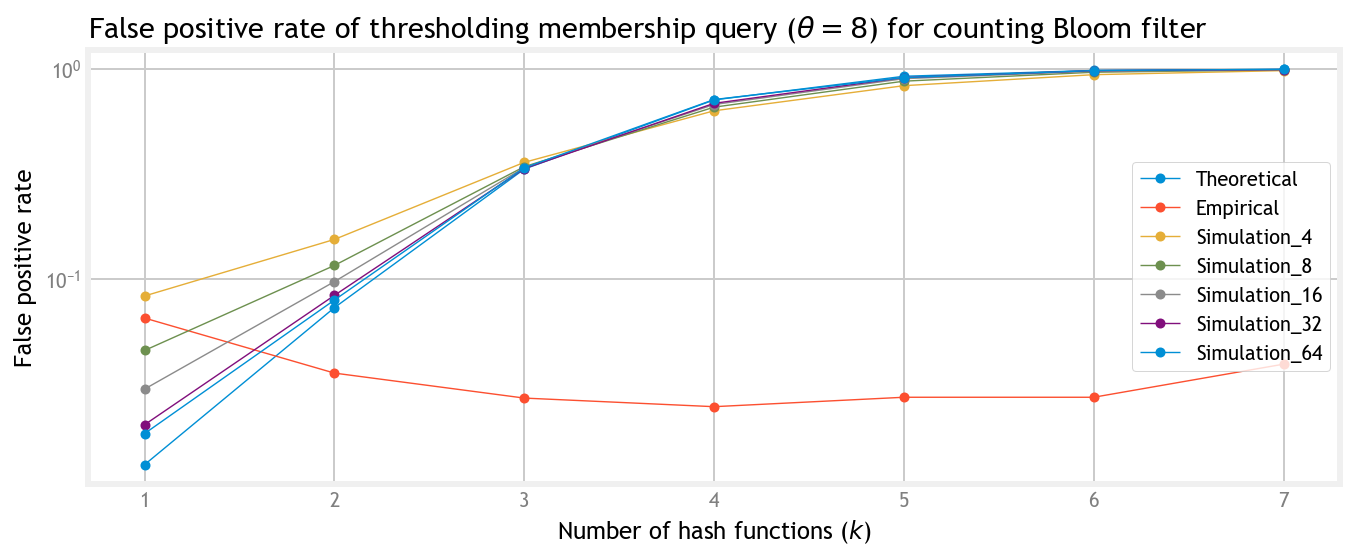

In [29]:
sim_list_y = [list_fp_thry, list_fp_emp]
sim_list_label = ['Theoretical', 'Empirical']
for i, p in enumerate(input_space_params):
    sim_list_y.append(list_list_fp_sim[i])
    sim_list_label.append(f'Simulation_{p}')
plot_lineplot_FPR(x = list_k, list_y = sim_list_y, list_label = sim_list_label, theta = theta, opt = False)

The histogram plotted using $\texttt{Simulation}$_$\texttt{64}$ shows most items are distinct.
This is not close to the empirical case, where there are even some kmers occurring more than 170 times. 

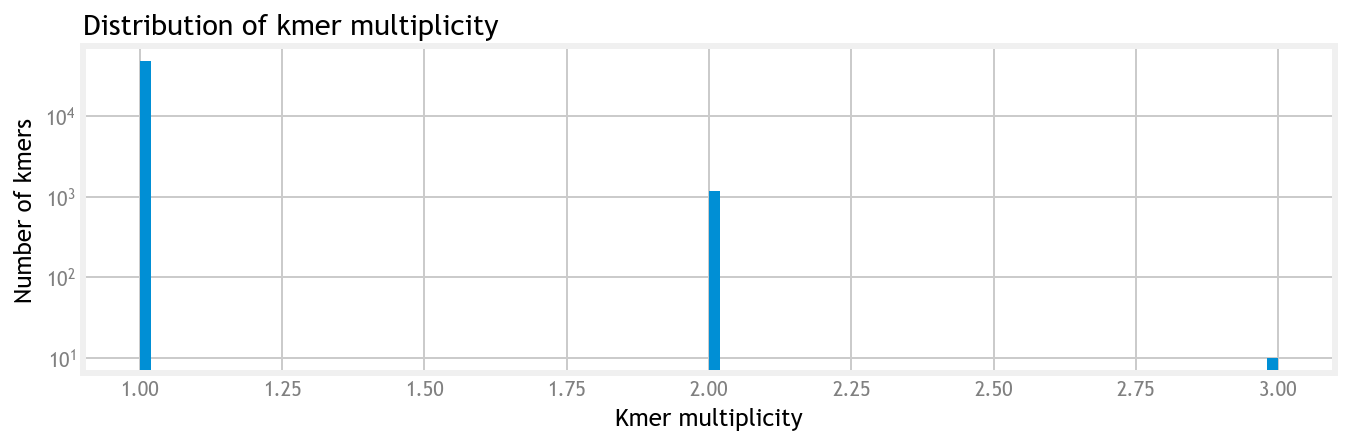

In [30]:
plot_hist(list_random_dataset[i])

## Explaining the gap between theory and genomic data

Here, we have showed that the simulation, when the input space is sufficiently large, gives similar results as the theoretical analysis by Kim et al.
However, we need to explain what causes the great gap between theory and empirical results -- the repetitiveness of input stream.
In typical Bloom filter analysis, researchers use the cardinality of input stream as the Bloom filter parameter $m$, which is reasonable because an item always set the same set of bins in a Bloom filter, regardless of its multiplicity.
On the other hand, when performing thresholding membership query using a counting Bloom filter, the $m$ parameter needs to the size of input stream, rather than its cardinality (the size of input set); otherwise, performing thresholding membership query to a stream where no element appears more than once is meaningless.
As a result, the theoretical work by Kim et al. doesn't hold for actual applications that rely on thresholding membership query, and we need more theoretical work in this field.

### Setting size of bins for counting Bloom filter

Since the memory usage of a CBF is a lot more than a typical BF, we are also interested in that if limiting the number of bits per CBF bin would affect the result.
With no deletion queries, it is natural that changing the size of bins doesn't affect thresholding membership query results.
We demonstrate that in the following plot by setting the `max_size` parameter of a CBF:

In [ ]:
list_tp_emp_limited, list_fn_emp_limited, list_fp_emp_limited, list_tn_emp_limited = evaluate_fpr_with_data(
    list_k = list_k,
    size_filter = size_filter,
    theta = theta,
    input_stream = list_kmer,
    true_set = true_set,
    false_set = false_set,
    max_size = 15 # [0, 15], so 4-bit
)
# plot_lineplot_FPR(x = list_k, list_y = [list_fp_emp_limited], list_label = ['Empirical_16'], theta = theta, opt = True)
plot_lineplot_FPR(x = list_k, list_y = [list_fp_emp, list_fp_emp_limited], list_label = ['Empirical', 'Empirical_16'], theta = theta, opt = False)

## Implement approximate counting

`ApproximateCountingBloomFilter` inherits `CountingBloomFilter`.

Member functions `insert()` is replaced.

In [ ]:
class ApproximateCountingBloomFilter(CountingBloomFilter):
    def insert(self, obj):
        # Perform approximate counting.
        # For each insertion, add 1 with probability 2^{-c}, where c is the current bin value
        
        for i in range(self.num_hash):
            list_target_idx = self.list_hasher[i].hash(obj) % self.size
            
            # Bernoulli trial with p = 2^{-c}
            rand_num = random.random()
            if self.table[list_target_idx] < self.max_size:
                if rand_num < 2 ** (- self.table[list_target_idx]):
                    self.table[list_target_idx] += 1
            # Do not update if the bin has reached max_size (print warning if verbose > 0)
            elif self.verbose > 0:
                print (f'insert(): fail to increment bin {list_target_idx} when inserting {obj} because the bin has reached max_size')

            # Print each step if verbose > 1
            if self.verbose > 1:
                print (f'insert(), insert {obj} to {list_target_idx}')
            

In [ ]:
test_cbf2 = ApproximateCountingBloomFilter(num_hash = 3, size = 30, verbose = 1, max_size = 5)
for obj in list_obj:
    test_cbf2.insert(obj)

print ('TestCBF2 after insertion:')
test_cbf2.print_filter()
test_cbf.print_filter()
print ()


##### Temporary workspace

In [ ]:
random.seed(0)
print (random.random())
print (random.random())
h1 = xxhash.xxh32(seed=0)
h1.reset()
h1.update("1")
print (h1.intdigest() % sys.maxsize)
h2 = xxhash.xxh32(seed=random.randint(0,sys.maxsize))
h2.reset()
h2.update("1")
print (h2.intdigest() % sys.maxsize)

In [ ]:
list_tp_emp, list_fn_emp, list_fp_emp, list_tn_emp = [], [], [], []

for k in list_k:
    cbf_unlimited = CountingBloomFilter(num_hash = k, size = size_filter)

    # Insertion
    for kmer in list_kmer:
        cbf_unlimited.insert(kmer)
    
    num_tp, num_tn, num_fp, num_fn = 0, 0, 0, 0
    for kmer in true_set:
        if cbf_unlimited.thresholding_contain(kmer, theta):
            num_tp += 1
        else:
            num_fn += 1
    for kmer in false_set:
        if cbf_unlimited.thresholding_contain(kmer, theta):
            num_fp += 1
        else:
            num_tn += 1

    list_tp_emp.append(num_tp / len(all_possible_kmers))
    list_fn_emp.append(num_fn / len(all_possible_kmers))
    list_fp_emp.append(num_fp / len(all_possible_kmers))
    list_tn_emp.append(num_tn / len(all_possible_kmers))
    
    del cbf_unlimited

In [ ]:

    
list_tp_sim = []
list_fn_sim = []
list_fp_sim = []
list_tn_sim = []
for k in list_k:
    cbf_sim_unlimited = CountingBloomFilter(num_hash = k, size = size_filter)

    # Insertion
    for kmer in random_dataset:
        cbf_sim_unlimited.insert(kmer)
    
    num_tp, num_tn, num_fp, num_fn = 0, 0, 0, 0
    for kmer in true_set:
        if cbf_sim_unlimited.thresholding_contain(kmer, theta):
            num_tp += 1
        else:
            num_fn += 1
    for kmer in false_set:
        if cbf_sim_unlimited.thresholding_contain(kmer, theta):
            num_fp += 1
        else:
            num_tn += 1

    list_tp_sim.append(num_tp / len(all_possible_kmers))
    list_fn_sim.append(num_fn / len(all_possible_kmers))
    list_fp_sim.append(num_fp / len(all_possible_kmers))
    list_tn_sim.append(num_tn / len(all_possible_kmers))
    
    del cbf_sim_unlimited

p_opt_sim = list_fp_sim.index(min(list_fp_sim))
k_opt_sim = list_k[p_opt_sim]

fig, ax = plt.subplots(figsize=(10,4))
ax.set_title(r'Simulated FPR of thresholding membership query $\theta =$' + f'{theta} for counting Bloom filter', loc = 'left')
ax.set_xlabel(f'Number of hash functions ($k$)')
ax.set_ylabel('False positive rate')
ax.set_yscale("log", nonposy='clip')
plt.plot(list_k, list_fp_sim, 'ko-', lw = 0.7, markersize = 4, label = f'Simulation')
plt.plot(list_k, list_fp_thry, 'bo-', lw = 0.7, markersize = 4, label = f'Theoretical')
plt.plot(k_opt_sim, min(list_fp_sim), 'ro', markersize=5, label = r'$k_{opt}$')
ax.legend(loc = 'right')
plt.show()

# References
- Kim, Kibeom, et al. "Analysis of Counting Bloom Filters Used for Count Thresholding." _Electronics_ 8.7 (2019): 779.